# Lecture 2

## Generating Images with Pre-trained CNNs

In preperation for this lecture we read _'Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps', Simonyan et al. 2013_ (https://arxiv.org/pdf/1312.6034.pdf).  
Here we want to implement their method to generate images that maximise the activation score of certain output units of AlexNet.  
We will use PyTorch, for more information and tutorials on PyTorch checkout:  
http://pytorch.org/docs/  
http://pytorch.org/tutorials/

In [1]:
#lazy-import all the numpy and matplotlib stuff you need
%pylab inline

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
from PIL import Image

#torch imports
import torch
from torch import optim
from torch.autograd import Variable
# import torch.nn.functional as F

#torchvision imports
import torchvision.models as models
from torchvision import transforms

#IPython imports
from IPython import display


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
#download alexnet if you haven't done so already and placed it in the current dirctory
model_file_name = 'alexnet-owt-4df8aa71.pth'
if not os.path.exists(pj(cwd, model_file_name)):
    !wget https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth 

In [3]:
#define alexnet architecture, load the pre-trained weights
alexnet = models.alexnet()
alexnet_weights = torch.load(pj(cwd, model_file_name))
alexnet.load_state_dict(alexnet_weights)

#set to evaluation mode to disable Dropout
alexnet.eval()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [4]:
# define pre and post processing for images using the torchvision helper functions
img_size = 224
prep = transforms.Compose([
        transforms.Scale((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
postp = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1,1,1]),
        transforms.ToPILImage(),
    ])

In [5]:
#load the list of object labels of the ImageNet Dataset that the network was trained on.
with open(pj(pj(os.path.dirname(cwd), 'Lecture1'), 'synset_words.txt')) as syn:
    class_labels = syn.readlines() 
class_labels = [label.split(' ', 1)[1].split('\n')[0] for label in class_labels]

In [8]:
#define image variable to optimise
opt_img = Variable(1e-3 * torch.zeros(1, 3, img_size, img_size), requires_grad=True)

#set all the optimisation parameters
max_iter = 100 #maximum number of iterations to take
lr = 1e0 #learning rate of the optimisation method
lam = 1e3 #weight on the L2 regularisation of the input image
optimizer = optim.SGD([opt_img], lr=lr)
target_class = 968
print('target class: ' + class_labels[target_class])

target class: cup


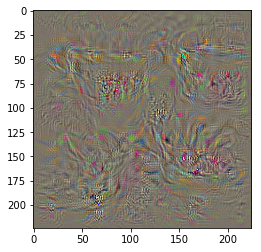

In [9]:
#run the optimisation
n_iter = 0 
while n_iter <= max_iter:
    optimizer.zero_grad()
    output = alexnet(opt_img)
    class_loss = -output[0,target_class]
    l2_loss = lam * (opt_img**2).mean()
    loss = class_loss + l2_loss
    #print loss and show intermediate result image
    print('iter: %d, total loss: %.3f, class loss: %.3f, l2 loss: %.3f'%(n_iter, loss.data[0], class_loss.data[0], l2_loss.data[0]))
    imshow(postp(opt_img.data.clone().squeeze()))
    display.display(gcf())
    display.clear_output(wait=True)
    loss.backward()
    optimizer.step()
    n_iter +=1

## Assignment for next Week
In general, these images don't look that natural. So let's run a little image generation competition until next week:  
__Please modify the code above to improve the quality of the generated images.__  


### Hints
- Play around with the learning rate and the regularisation parameter, try decreasing the learning rate over time.
- Try other optimisation methods from the torch.optim module.
- Checkout this work: _Understanding Neural Networks Through Deep Visualization, Yosinksi et al. 2015_ (https://arxiv.org/pdf/1506.06579.pdf) and test their ideas to regularise the image generation.
- Come up with your own super cool regularisation method that will revolutionise Image Synthesis with CNNs!

And remember, I will get an ice cream for whoever wins the competition ;-)